Provo se la NLL stavolta fa una cosa piu sensata

In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dtype = torch.float32

In [127]:
import importlib
# importlib.reload(utils)
# importlib.reload(selex_distribution)
# importlib.reload(energy_models)
importlib.reload(sampling)
# importlib.reload(training)
# importlib.reload(callback)

<module 'sampling' from '/home/scrotti/Aptamer2025py/sampling.py'>

## Generate

In [140]:
tr = tree.Tree()
tr.add_node(-1, name = "round 1 with selection")
tr.add_node(0, name = "round 2 with selection")

selected_modes = torch.BoolTensor(
    [[1],
     [1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == tr.get_n_nodes()
n_rounds = n_selection_rounds + 1

In [141]:
L, q = 45, 4

In [142]:
def hamming(x:torch.tensor, y: torch.tensor):
    L = x.size(-2)
    return L - (x * y).sum((-2, -1)).to(torch.int)

Pick as wildtype something which is well-aligned with ps

In [143]:
generator = torch.Generator().manual_seed(0)

h_teacher = torch.randn(L, q, dtype=dtype, generator=generator)

wt_oh = sampling.sample_indep_sites(h_teacher, n_samples=1, generator=generator, beta=7.0).squeeze()
torch.nn.functional.cosine_similarity(wt_oh, h_teacher.exp()).mean()

tensor(0.7814)

In [144]:
mutation_rate = 0.3
k_teacher = utils.field_from_wildtype(wt_oh, mutation_rate)

Ns0_teacher = energy_models.IndepSites(k_teacher)
ps_teacher = selex_distribution.MultiModeDistribution(energy_models.IndepSites(h_teacher), normalized=False)
model_teacher = selex_distribution.MultiRoundDistribution(Ns0_teacher, ps_teacher, tr, selected_modes)
model_teacher.train(mode=False);

In [145]:
n_chains = 10**5
chains_teacher = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)

In [ ]:
n_sweeps = 50
energies = model_teacher.sample(chains_teacher, n_sweeps)

In [ ]:
sequences_oh = chains_teacher
total_reads = total_reads = torch.Tensor([sequences_oh.shape[1] for _ in range(n_rounds)])

In [ ]:
d = hamming(wt_oh, sequences_oh[0])
plt.hist(d, bins=L+1, density=True)
plt.axvline([mutation_rate * L], color='r', label='Nominal mutation rate')
plt.xlabel('Hamming distance from WT');

## Learn

In [ ]:
k = torch.randn(L, q, dtype=dtype)
h = torch.randn(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
ps = selex_distribution.MultiModeDistribution(energy_models.IndepSites(h), normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes, learn_selection_strength=False)

In [ ]:
batch_size = 10**4
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [ ]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [ ]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher)]

In [ ]:
n_sweeps = 10
lr = 0.1
target_pearson = 1
max_epochs = 4000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks, log_weights=log_weights)

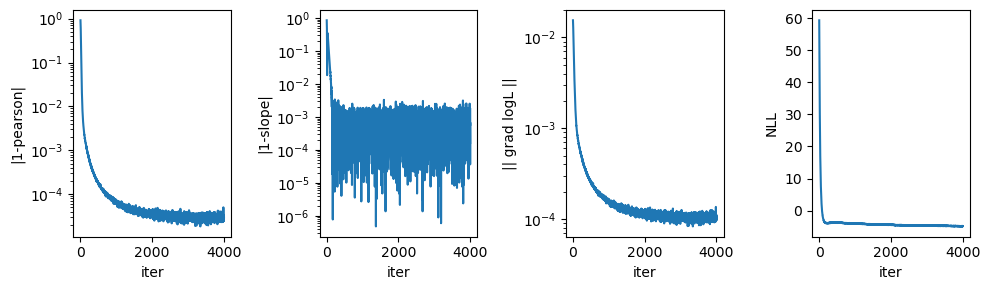

In [163]:
callbacks[0].plot();

INDEP SITES


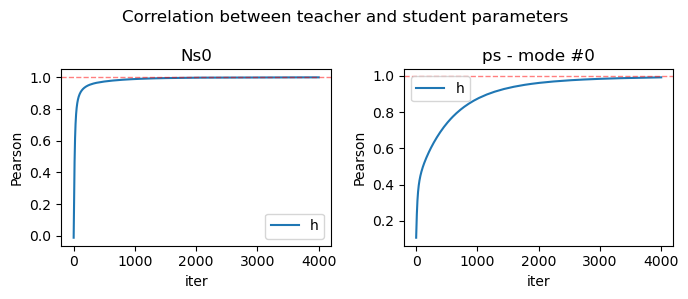

In [164]:
callbacks[1].plot(figsize=(7,3))
print('INDEP SITES')

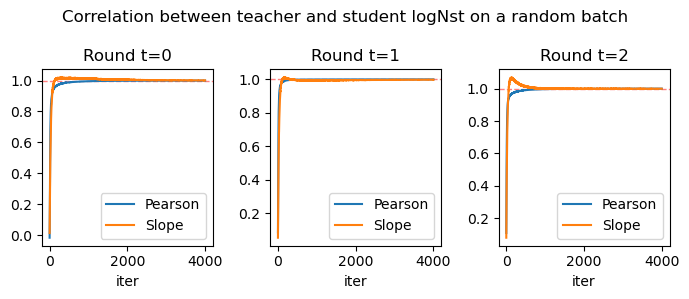

In [165]:
callbacks[1].plot_pearson_energies(figsize=(7,3));

0.9997400045394897

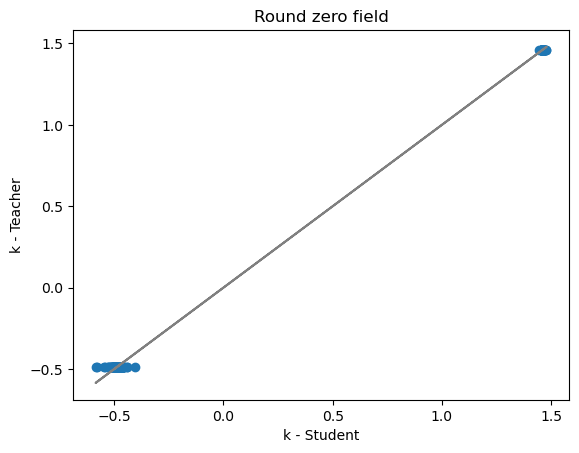

In [166]:
X = model.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.round_zero.set_zerosum_gauge().h.detach().reshape(-1)
plt.scatter(X, Y)
plt.plot(X, X, color='gray')
plt.xlabel('k - Student'); plt.ylabel('k - Teacher')
plt.title('Round zero field')
utils.compute_pearson(X, Y)

0.9921979904174805

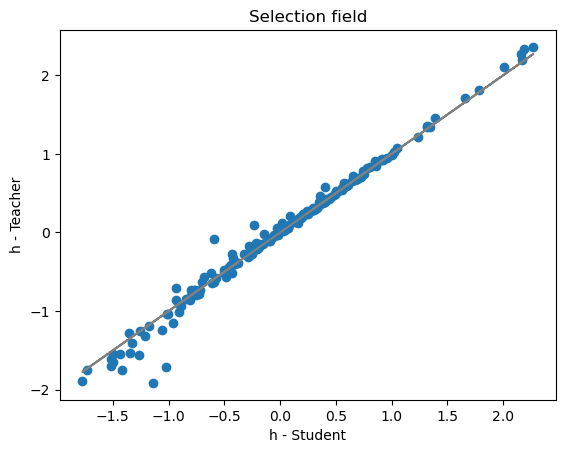

In [167]:
X = model.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
Y = model_teacher.selection.modes[0].set_zerosum_gauge().h.detach().reshape(-1)
plt.scatter(X, Y)
plt.plot(X, X, color='gray')
plt.xlabel('h - Student'); plt.ylabel('h - Teacher')
plt.title('Selection field')
utils.compute_pearson(X, Y)

## Compute energies for sequences far away from the wildtype

In [168]:
wt_far_oh = one_hot(torch.randint(q, (L,)))
k_far = utils.field_from_wildtype(wt_far_oh, mutation_rate)
hamming(wt_oh, wt_far_oh)

tensor(34, dtype=torch.int32)

In [169]:
X_far = sampling.sample_indep_sites(k_far, n_samples=chains_teacher[0].size(0))
X_close = sequences_oh[0]

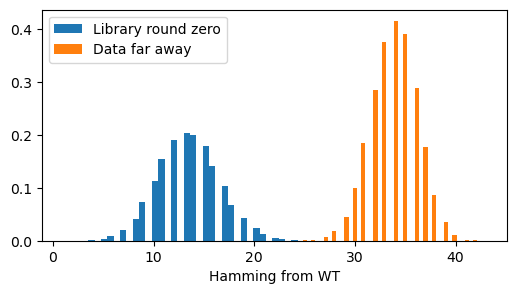

In [170]:
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(hamming(wt_oh, X_close), label='Library round zero', bins=L+1, density=True)
ax.hist(hamming(wt_oh, X_far), label='Data far away', bins=L+1, density=True)
ax.set_xlabel('Hamming from WT')
ax.legend();

INDEP SITES


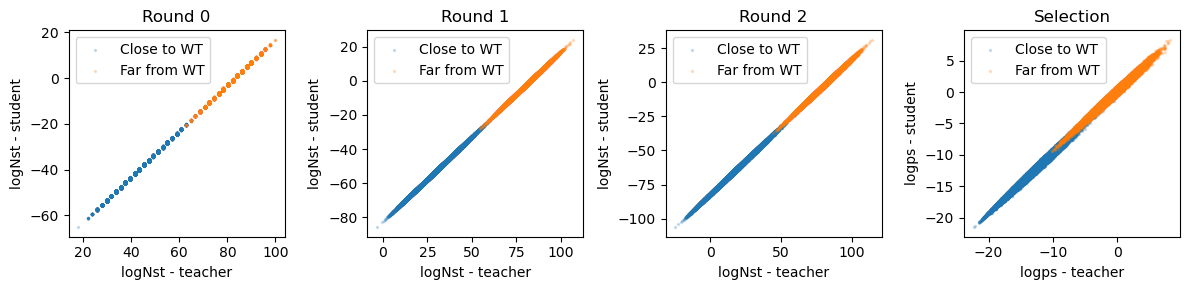

In [171]:
fig, axes = plt.subplots(1, n_rounds+1, figsize=(12, 3))

alpha = 0.2

for t in range(n_rounds):
    ax = axes[t]
    en_teacher = model_teacher.compute_energy_up_to_round(X_close, t).detach()
    en_student = model.compute_energy_up_to_round(X_close, t).detach()
    ax.scatter(en_teacher, en_student, label='Close to WT', s=2, alpha=alpha)
    en_teacher = model_teacher.compute_energy_up_to_round(X_far, t).detach()
    en_student = model.compute_energy_up_to_round(X_far, t).detach()
    ax.scatter(en_teacher, en_student, label='Far from WT', s=2, alpha=alpha)
    ax.legend()
    ax.set_xlabel('logNst - teacher'); ax.set_ylabel('logNst - student')
    ax.set_title(f'Round {t}')
    
ax = axes[-1]
en_teacher = model_teacher.selection_energy_at_round(X_close, 1).detach()
en_student = model.selection_energy_at_round(X_close, 1).detach()
ax.scatter(en_teacher, en_student, label='Close to WT', s=2, alpha=alpha)
en_teacher = model_teacher.selection_energy_at_round(X_far, 1).detach()
en_student = model.selection_energy_at_round(X_far, 1).detach()
ax.scatter(en_teacher, en_student, label='Far from WT', s=2, alpha=alpha)
ax.legend()
ax.set_xlabel('logps - teacher'); ax.set_ylabel('logps - student')
ax.set_title(f'Selection')
fig.tight_layout()

print('INDEP SITES')

## Predict empirical enrichments

In [ ]:
# n_sweeps = 20
# n_chains = 10**5
# chains_student = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
# _ = model.sample(chains_student, n_sweeps)

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(9,3))
# markersize = 1
# for t in range(n_rounds):
#     pcs_data, pcs_gen = utils.compute_pca(sequences_oh[t], chains_student[t])
#     ax = axes[t]
#     ax.scatter(pcs_data[:,0], pcs_data[:,1], label='Data', s=markersize)
#     ax.scatter(pcs_gen[:,0], pcs_gen[:,1], label='Generated', s=markersize)
#     ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2')
#     ax.set_title(f'Round {t}')
#     ax.legend()
# fig.suptitle('PCA on teacher student, indep sites')
# fig.tight_layout()

In [ ]:
# t = 0
# pcs, _ = utils.compute_pca(sequences_oh[t], chains_student[t])
# energies = model_teacher.compute_energy_up_to_round(sequences_oh[t], t).detach()
# plt.scatter(pcs[:,0], pcs[:,1], label='Data', s=markersize, c=energies)
# plt.colorbar()